In [1]:
import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
animals = pd.read_csv("/Users/adamzhang/Documents/personal/ark_nova/data/animals.csv")

In [3]:
animals.tail(5)

,card_id,name,latin_name,continent,type,is_bear,cost,animal_level,standard_enclosure_size,reptile_house_size,...,appeal_points,conservation_points,reputation_points,continent_bonus,type_bonus,bear_bonus,skill_name,skill_description,skill_2_name,skill_2_description
123,524,MANGALICA,Sus scrofa form. domestica,NaN,Petting Zoo,0,7,1,0,0,...,0,0,0,0,1,0,Petting Zoo Animal,Gain 3 appeal points for each Petting Zoo Anim...,Digging 1,Choose up to 1x: Discard 1 card from the displ...
124,525,GUINEA PIG,Cavia porcellus form. domestica,NaN,Petting Zoo,0,7,1,0,0,...,0,0,0,0,1,0,Petting Zoo Animal,Gain 3 appeal points for each Petting Zoo Anim...,NaN,NaN
125,526,ALPACA,Vicugna pacos,NaN,Petting Zoo,0,7,1,0,0,...,0,0,0,0,1,0,Petting Zoo Animal,Gain 3 appeal points for each Petting Zoo Anim...,NaN,NaN
126,527,COCONUT LORIKEET,Trichoglossus haematodus,NaN,Petting Zoo,0,7,1,0,0,...,0,0,0,0,1,0,Petting Zoo Animal,Gain 3 appeal points for each Petting Zoo Anim...,NaN,NaN
127,528,BENNETT'S WALLABY,Macropus rufogriseus,NaN,Petting Zoo,0,7,1,0,0,...,0,0,0,0,1,0,Petting Zoo Animal,Gain 3 appeal points for each Petting Zoo Anim...,Pouch 1,You may place 1 card from you hand under this ...


## Q1 type distribution
Generate a graph for the type distribution of animals type VS category

In [4]:
duckdb.sql("""select distinct continent from animals""")

┌───────────┐
│ continent │
│  varchar  │
├───────────┤
│ Africa    │
│ Americas  │
│ Europe    │
│ Australia │
│ Asia      │
│ NULL      │
└───────────┘

In [5]:
duckdb.sql("""
           select 
                count(case when continent = 'Africa' then 1 else null end) as Africa,
                count(case when continent = 'Asia' then 1 else null end) as Asia,
                count(case when continent = 'Australia' then 1 else null end) as Australia,
                count(case when continent = 'Americas' then 1 else null end) as Americas,
                count(case when continent = 'Europe' then 1 else null end) as Europe,
           from 
                animals
           """)

┌────────┬───────┬───────────┬──────────┬────────┐
│ Africa │ Asia  │ Australia │ Americas │ Europe │
│ int64  │ int64 │   int64   │  int64   │ int64  │
├────────┼───────┼───────────┼──────────┼────────┤
│     26 │    26 │        20 │       26 │     20 │
└────────┴───────┴───────────┴──────────┴────────┘

In [6]:
df_continent = duckdb.sql("""
           SELECT continent, type, COUNT(*) as count
            FROM animals
            GROUP BY continent, type
            ORDER BY continent, type
           """).to_df()
df_continent

,continent,type,count
0,Africa,Bird,5
1,Africa,Herbivore,5
2,Africa,Predator,5
3,Africa,Primate,6
4,Africa,Reptile,5
5,Americas,Bird,5
6,Americas,Herbivore,5
7,Americas,Predator,5
8,Americas,Primate,6
9,Americas,Reptile,5


In [7]:
pivot_df = df_continent.pivot(index='type', columns='continent', values='count').fillna(0).astype(int)
pivot_df = pivot_df.reindex(['Primate','Predator','Herbivore','Bird','Reptile','Petting Zoo'])

In [8]:
df_bear = duckdb.sql("""
           SELECT 
                count(case when continent = 'Africa' then 1 else null end) as Africa,
                count(case when continent = 'Asia' then 1 else null end) as Asia,
                count(case when continent = 'Australia' then 1 else null end) as Australia,
                count(case when continent = 'Americas' then 1 else null end) as Americas,
                count(case when continent = 'Europe' then 1 else null end) as Europe
            FROM animals
            where is_bear = 1
           """).to_df()
df_bear

,Africa,Asia,Australia,Americas,Europe
0,0,4,1,3,1


In [9]:
pivot_df.loc['bear'] = [0] + [df_bear[continent].to_list()[0] for continent in pivot_df.columns.to_list()[1:]]

In [10]:
pivot_df

continent,NaN,Africa,Americas,Asia,Australia,Europe
type,,,,,,
Primate,0,6,6,6,0,0
Predator,0,5,5,5,5,5
Herbivore,0,5,5,5,5,5
Bird,0,5,5,5,5,5
Reptile,0,5,5,5,5,5
Petting Zoo,10,0,0,0,0,0
bear,0,0,3,4,1,1


Insights:

- Predator, Herbivore, Bird, Reptile all have 25 cards, primate has only 18, petting zoo has 10 and 9 bears in total
- primate only have 18 cards evenly distributed in Africa, Asia and Americas
- bear is mainly located in Asia (4) and America (3) with only 1 each in Europe and Australia. No bear in Africa

## Q2 enclosure size

可以分析的角度是:

- 按continent进行分类的enclosure distribution
- 按animal category进行分类的enclosure distribution



In [11]:
animals.head(5)

,card_id,name,latin_name,continent,type,is_bear,cost,animal_level,standard_enclosure_size,reptile_house_size,...,appeal_points,conservation_points,reputation_points,continent_bonus,type_bonus,bear_bonus,skill_name,skill_description,skill_2_name,skill_2_description
0,401,CHEETAH,Acinonyx jubatus,Africa,Predator,0,17,1,5,0,...,6,0,0,1,2,0,Sprint 3,Draw 3 cards from the deck,NaN,NaN
1,402,LION,Panthera leo,Africa,Predator,0,16,1,4,0,...,9,0,0,1,1,0,Pack,Gain 1 appeal point for each predator icon in ...,NaN,NaN
2,403,LEOPARD,Panthera pardus,Africa,Predator,0,20,1,3,0,...,7,1,0,1,1,0,Hunter 4,Reveal the 4 topmost cards of the deck. Choose...,NaN,NaN
3,404,CARACAL,Caracal caracal,Africa,Predator,0,9,1,2,0,...,4,0,0,1,1,0,Hunter 2,Reveal the 2 topmost cards of the deck. Choose...,NaN,NaN
4,405,FENNEC FOX,Vulpes zerda,Africa,Predator,0,8,1,1,0,...,3,0,0,1,1,0,Clever,"After finishing this action, you may place any...",NaN,NaN


In [12]:
enclosure = duckdb.sql("""select 
                standard_enclosure_size, 
                count(*) as count
              from 
                animals
              group by standard_enclosure_size
              order by standard_enclosure_size DESC""").to_df()
enclosure

,standard_enclosure_size,count
0,5,19
1,4,20
2,3,24
3,2,31
4,1,24
5,0,10


In [13]:
duckdb.sql("""select distinct continent from animals""")

┌───────────┐
│ continent │
│  varchar  │
├───────────┤
│ Europe    │
│ Asia      │
│ NULL      │
│ Australia │
│ Africa    │
│ Americas  │
└───────────┘

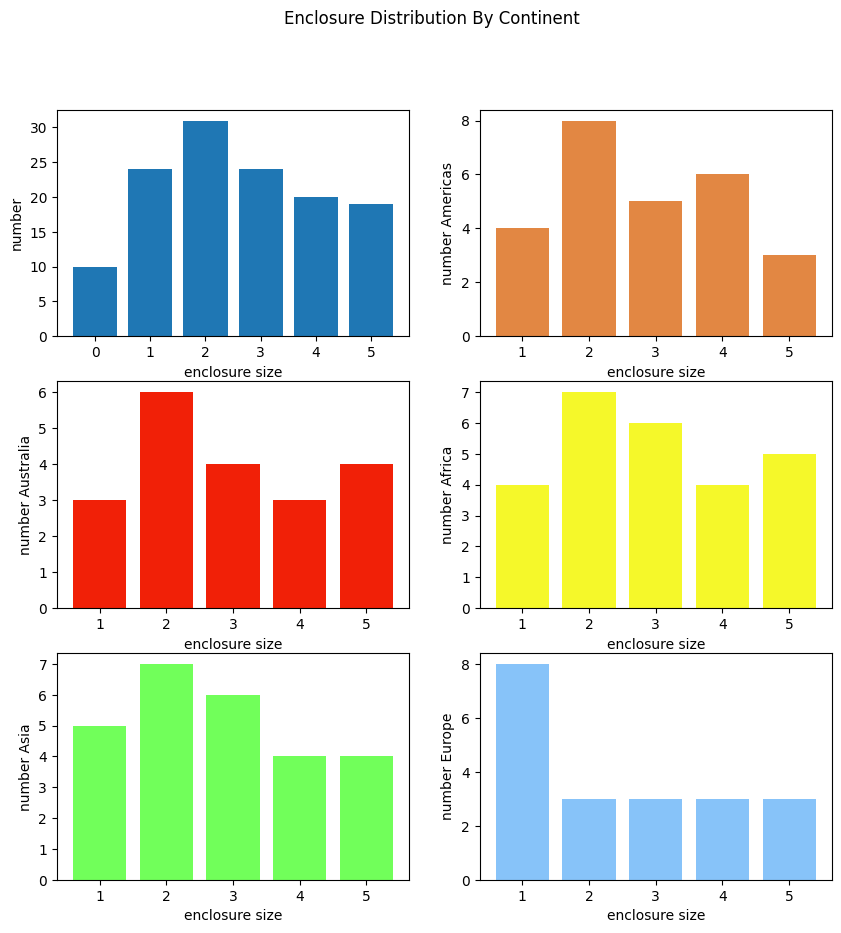

In [14]:
fig, axes = plt.subplots(3,2,figsize=(10,10))
fig.suptitle("Enclosure Distribution By Continent")
axes = axes.flatten()
axes[0].bar(enclosure["standard_enclosure_size"],enclosure["count"])
axes[0].set_xlabel("enclosure size")
axes[0].set_ylabel("number")

continents = {
    "Americas" : {
        "index":1,
        "color" : "#e28743"
      },
    "Australia": {
        "index":2,
        "color" : "#F12007"
      },
    "Africa": {
        "index":3,
        "color" : "#F5F82A"
      },
    "Asia" : {
        "index":4,
        "color" : "#71FF5A"
      },
    "Europe" : {
        "index":5,
        "color" : "#87C3F9"
      },
}



for continent,i in continents.items():
    enclosure = duckdb.sql(f"""select 
                standard_enclosure_size, 
                count(*) as count
              from 
                animals
            where continent = '{continent}'
              group by standard_enclosure_size
              order by standard_enclosure_size DESC              
              """).to_df()
    
    axes[i["index"]].bar(enclosure["standard_enclosure_size"],enclosure["count"],color = i["color"])
    axes[i["index"]].set_xlabel("enclosure size")
    axes[i["index"]].set_ylabel(f"number {continent}")
    

Conclusion:

- size 2的动物最多 (让地图奖励make sense)
- 五大洲里，size 1动物最多的是europe, 为8只，其它size都为2只
- 绝大多数动物都是size 2-3
- 美洲的4格动物最多，其它除欧洲外的州都是5格动物最多

对打法的优化

- 前期盲build, 尽量build size 3 (cover 3 and 2), 后期build size 5 (cover 4 and 5)

In [15]:
duckdb.sql("select distinct type from animals")

┌─────────────┐
│    type     │
│   varchar   │
├─────────────┤
│ Bird        │
│ Primate     │
│ Reptile     │
│ Petting Zoo │
│ Herbivore   │
│ Predator    │
└─────────────┘

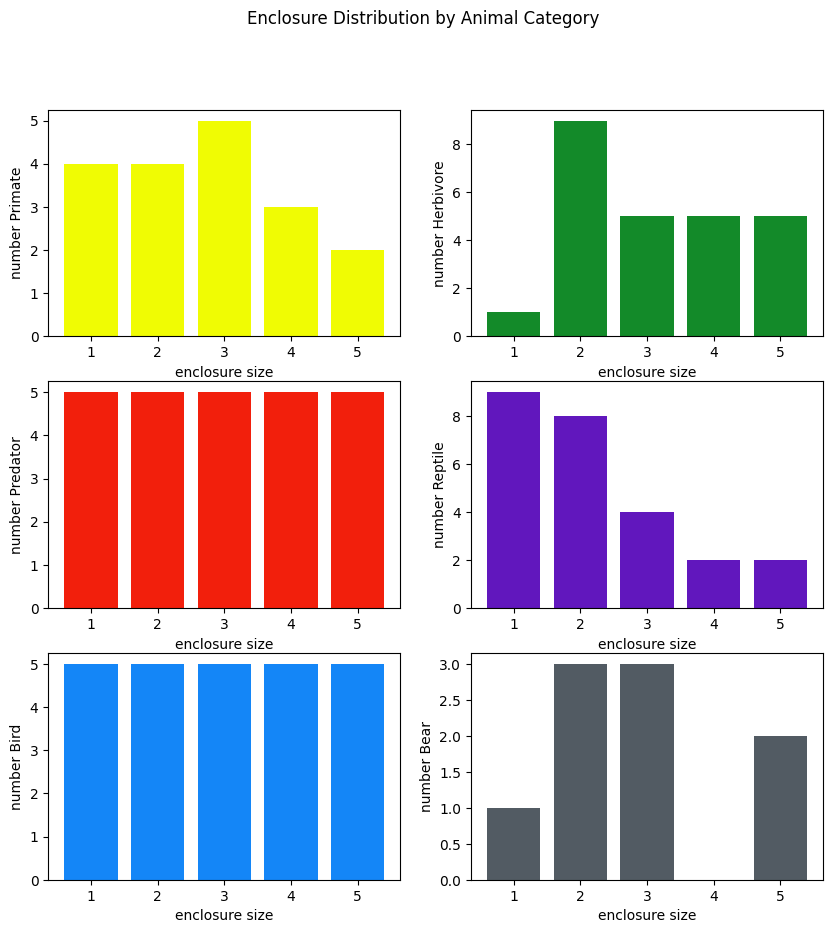

In [16]:
fig, axes = plt.subplots(3,2,figsize=(10,10))
fig.suptitle("Enclosure Distribution by Animal Category")
axes = axes.flatten()

types = {
    "Primate" : {
        "index":0,
        "color" : "#f0fc03"
      },
    "Herbivore": {
        "index":1,
        "color" : "#138a29"
      },
    "Predator": {
        "index":2,
        "color" : "#f21f0c"
      },
    "Reptile" : {
        "index":3,
        "color" : "#6117bd"
      },
    "Bird" : {
        "index":4,
        "color" : "#1486f7"
      },
    "Bear" : {
        "index":5,
        "color" : "#525b63"
    }
}


for type,i in types.items():
    if type != "Bear":
        enclosure = duckdb.sql(f"""select 
                    standard_enclosure_size, 
                    count(*) as count
                from 
                    animals
                where type = '{type}'
                group by standard_enclosure_size
                order by standard_enclosure_size DESC              
                """).to_df()
    else:
        enclosure = duckdb.sql(f"""select 
                    standard_enclosure_size, 
                    count(*) as count
                from 
                    animals
                where is_bear = 1
                group by standard_enclosure_size
                order by standard_enclosure_size DESC              
                """).to_df() 
    
    axes[i["index"]].bar(enclosure["standard_enclosure_size"],enclosure["count"],color = i["color"])
    axes[i["index"]].set_xlabel("enclosure size")
    axes[i["index"]].set_ylabel(f"number {type}")
    

concolusion
- bird, predator size distribution很均匀，都为5
- herbivore size 2最多，reptile size 1 and 2最多

follow-up

- 鸟在large bird aviary的分布
- reptile在retpele house的分布

### Q3.1 reptile house分布情况

In [17]:
enclosure = duckdb.sql("""select 
                    reptile_house_size, 
                    count(*) as count
                from 
                    animals
                where type = 'Reptile'
                group by reptile_house_size
                order by reptile_house_size DESC              
                """).to_df()
enclosure

,reptile_house_size,count
0,3,2
1,2,6
2,1,8
3,0,9


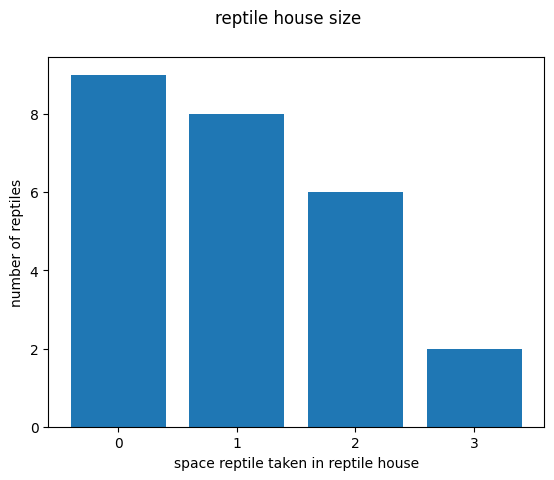

In [18]:
fig, ax = plt.subplots()
fig.suptitle("reptile house size")
ax.bar(enclosure["reptile_house_size"],enclosure["count"])
ax.set_xlabel("space reptile taken in reptile house")
ax.set_ylabel("number of reptiles")
x_ticks = np.arange(int(min(enclosure["reptile_house_size"])), int(max(enclosure["reptile_house_size"])) + 1)
ax.set_xticks(x_ticks)


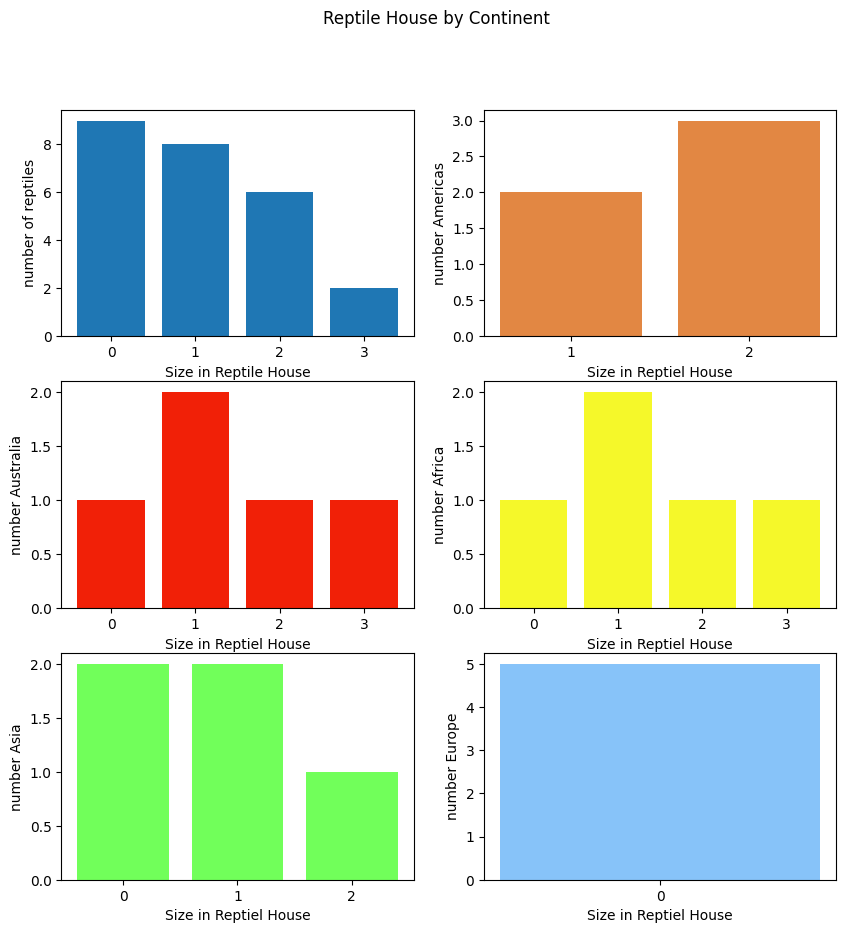

In [19]:

fig, axes = plt.subplots(3,2,figsize=(10,10))
fig.suptitle("Reptile House by Continent")
axes = axes.flatten()
# axes[0].bar(enclosure["standard_enclosure_size"],enclosure["count"])
# axes[0].set_xlabel("enclosure size")
# axes[0].set_ylabel("number")

axes[0].bar(enclosure["reptile_house_size"],enclosure["count"])
axes[0].set_xlabel("Size in Reptile House")
axes[0].set_ylabel("number of reptiles")
x_ticks = np.arange(int(min(enclosure["reptile_house_size"])), int(max(enclosure["reptile_house_size"])) + 1)
ax.set_xticks(x_ticks)



continents = {
    "Americas" : {
        "index":1,
        "color" : "#e28743"
      },
    "Australia": {
        "index":2,
        "color" : "#F12007"
      },
    "Africa": {
        "index":3,
        "color" : "#F5F82A"
      },
    "Asia" : {
        "index":4,
        "color" : "#71FF5A"
      },
    "Europe" : {
        "index":5,
        "color" : "#87C3F9"
      },
}



for continent,i in continents.items():
    enclosure = duckdb.sql(f"""select
                                reptile_house_size, 
                                count(*) as count
                            from 
                                animals
                            where type = 'Reptile' and continent = '{continent}'  
                                group by reptile_house_size
                                order by reptile_house_size DESC              
                """).to_df()


    
    axes[i["index"]].bar(enclosure["reptile_house_size"],enclosure["count"],color = i["color"])
    axes[i["index"]].set_xlabel("Size in Reptiel House")
    axes[i["index"]].set_ylabel(f"number {continent}")
    x_ticks = np.arange(int(min(enclosure["reptile_house_size"])), int(max(enclosure["reptile_house_size"])) + 1)
    # x_ticks = np.arange(int(min(enclosure["reptile_house_size"])), int(max(enclosure["reptile_house_size"])) + 1)
    axes[i["index"]].set_xticks(x_ticks)
    


conclusion

- 所有爬行动物都能住在reptile house中
- 大多数reptile都占据1 or 0格in reptile house
- 欧洲所有reptile都只占0格
 
    

### Q3.2 aviary size 

## Q3 性价比

到底哪个动物性价比, 比较高呢? 其实很难measure, 比较常见的方法为给不同技能加权重，但有以下几个弊端:
- reputation价值的浮动, 8 rep之前很重要，8 rep之后相对没有那么重要
- 技能的衡量，比如determination, 你该怎么算价值? clever技能关乎你现有的5 actions cards的order以及游戏的进程(前中后期).

这些因素都导致不管你怎么加权重，都是很主观的. 最好还是根据game play进行判断

## Q4 rock icon and water icon

有water icon和rock icon的animal的distribution是什么样的? 分析角度有:
- enclosure size wise
- animal category wise

还可以单纯比较rock icon和water icon的数量, 可以帮助你做decision making 


> 如果你同时获得aquarium and cable car, 你选择哪个? 你也可以全都要，但并不是特别efficient, 因为你会
> - 浪费
> - AS
